# Libraries

In [14]:
## libraries
import sys
import os
import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
import numpy as np
from math import cos, asin, sqrt
import time

%matplotlib inline

# to import Database class from data_collection folder
module_path = os.path.abspath(os.path.join('..')+'/data_collection')
if module_path not in sys.path:
    sys.path.append(module_path)

# now that the folder is in the path, ../data_collection/database.py can be imported
from database import Database

# Data Collection Summary:

- Yelp API search yieleded 4098 halal-related restaurants in NYC
- 5092 reviews containinf the word Halal were found in those restaurants
- In particular, 838 of those restaurants had reveiws that contained the word Halal


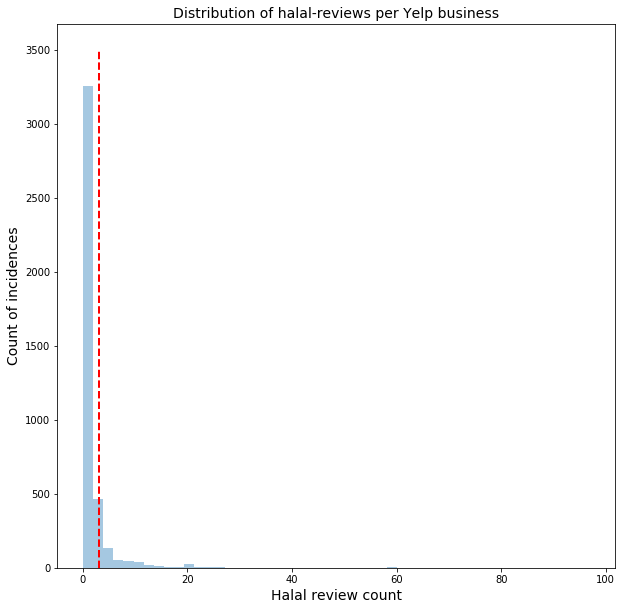

In [2]:
db = Database()

# get yelp businesses
yelp_sql = '''SELECT * FROM businesses WHERE url LIKE '%yelp%' '''
yelp_df = db.select_df(yelp_sql)
print('\033[1m- Yelp API search yieleded {} halal-related restaurants in NYC'.format(yelp_df.shape[0]))

# get halal-reviews (reviews that include the word 'halal')
reviews_sql = '''SELECT * FROM reviews'''
reviews_df = db.select_df(reviews_sql)
print('- {} reviews containinf the word Halal were found in those restaurants'.format(reviews_df.shape[0]))

# subset of yelp businesses with halal-reviews
halal_yelp_df = yelp_df[ yelp_df.platform_id.isin(reviews_df.restaurant_id.unique())]
print('- In particular, {} of those restaurants had reveiws that contained the word Halal\033[0m'.format(halal_yelp_df.shape[0]))


# add column with num of scraped reviews per business
counts = reviews_df.restaurant_id.value_counts()
yelp_df = yelp_df.assign(halal_review_count=yelp_df.platform_id.map(dict(zip(counts.index, counts.values))))
yelp_df.halal_review_count = yelp_df.halal_review_count.fillna(0)

# plot histogram of counts per restaurant
plt.figure(figsize=(10,10))
g = sns.distplot(yelp_df.halal_review_count, kde = False)
g.set_title('Distribution of halal-reviews per Yelp business', size=14)
g.set_xlabel('Halal review count', size=14)
g.set_ylabel('Count of incidences', size=14)
plt.plot([3, 3],[0, 3500], linewidth=2, linestyle='dashed', color='r') # cutoff between 2 & 5. To remove noise
plt.show()

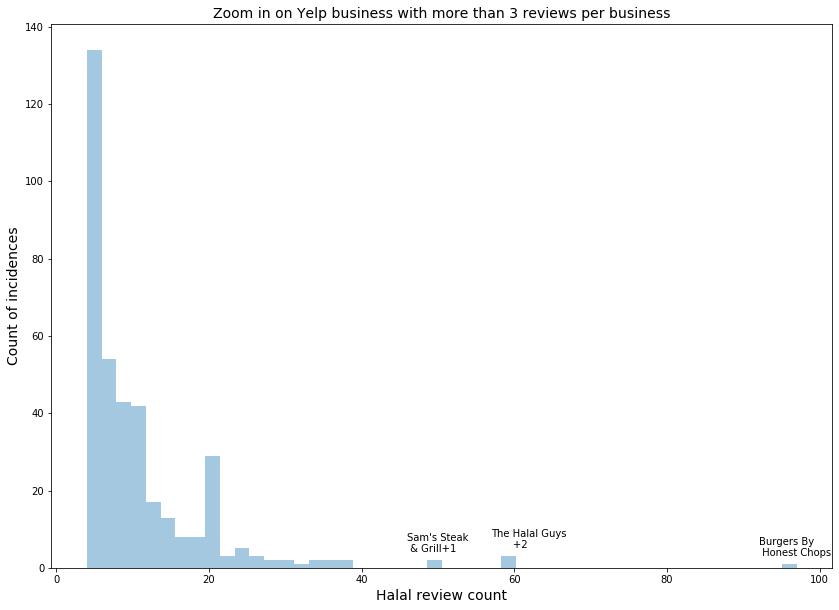

In [3]:
# plot histogram of Yelp businesses with more than 10 halal-reviews
fig, ax = plt.subplots(figsize=(14,10))
g = sns.distplot(yelp_df.halal_review_count[yelp_df.halal_review_count>3], kde = False, ax=ax)
g.set_title('Zoom in on Yelp business with more than 3 reviews per business', size=14)
g.set_xlabel('Halal review count', size=14)
g.set_ylabel('Count of incidences', size=14)

# Add labels to the plot
style = dict(size=10)
ax.text(92, 3, 'Burgers By\n Honest Chops', **style)
ax.text(57, 5, 'The Halal Guys\n       +2', **style)
ax.text(46, 4, "Sam's Steak\n & Grill+1", **style)
plt.show()

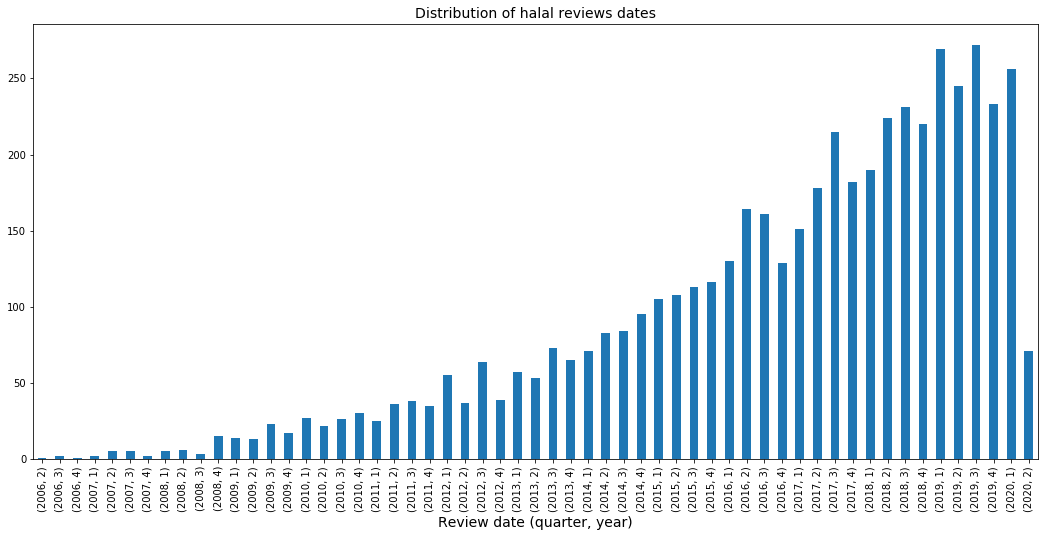

In [4]:
# distribution of reviews' dates
reviews_df.review_date[0]
# df["date"] = df["date"].astype("datetime64")
# df.groupby(df["date"].dt.month).count().plot(kind="bar")
ax, fig = plt.subplots(figsize=(18,8))
reviews_df.review_date = reviews_df['review_date'].astype('datetime64')
reviews_df.groupby([reviews_df.review_date.dt.year, reviews_df.review_date.dt.quarter])['id'].count().plot(kind='bar')
plt.title('Distribution of halal reviews dates', size=14)
plt.xlabel('Review date (quarter, year)', size=14)
plt.show()

# Target Feature 
## Halal restaurants from Zabiha.com & Zomato.com

- 745 Halal-confirmed restaurants were found on Zabiha.com
- 340 Halal-tagged restaurants were found on Zomato.com


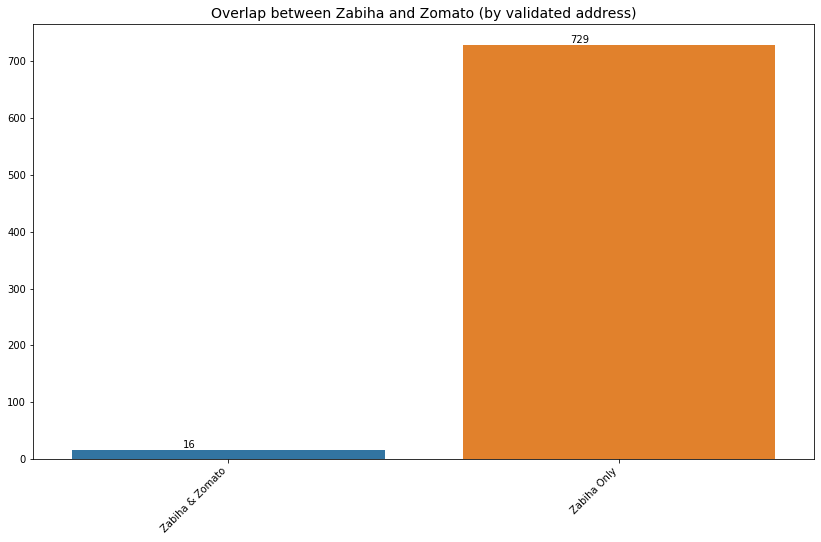

In [5]:
target_df = pd.read_csv('/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/data/data_collection/target_feature/zabiha_list_DEPRECATED.csv',\
                        index_col=0)
print('\033[1m- {} Halal-confirmed restaurants were found on Zabiha.com'.format(sum(target_df['source'] == 'Zabiha'))) # 745 restaurants from Zabiha.com
print('- {} Halal-tagged restaurants were found on Zomato.com\033[0m'.format(sum(target_df['source'] == 'Zomato'))) # 340 restaurants from Zomato.com

target_df['validated_address'] = target_df['validated_address'].str.lower()
target_match = target_df['validated_address'][target_df.source == 'Zabiha'].isin(target_df['validated_address'][target_df.source == 'Zomato'])
target_match_count = [sum(target_match), len(target_match)-sum(target_match)]

plt.figure(figsize=(14,8))
g = sns.barplot(x=['Zabiha & Zomato','Zabiha Only'], y=target_match_count)
g.set_title('Overlap between Zabiha and Zomato (by validated address)', size=14)
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                ha='center', va='bottom', color= 'black')

## Is this because of the address validation? What if we comapre by name?

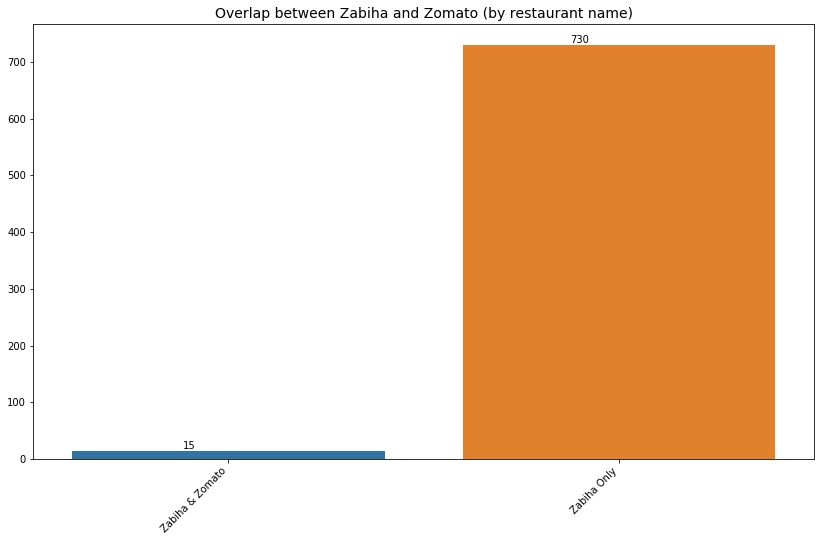

In [6]:
plt.figure(figsize=(14,8))
target_df['name'] = target_df['name'].str.lower()
target_match = target_df['name'][target_df.source == 'Zabiha'].isin(target_df['name'][target_df.source == 'Zomato'])
target_match_count = [sum(target_match), len(target_match)-sum(target_match)]
g = sns.barplot(x=['Zabiha & Zomato','Zabiha Only'], y=target_match_count)
g.set_title('Overlap between Zabiha and Zomato (by restaurant name)', size=14)
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                ha='center', va='bottom', color= 'black')

## How many Yelp restaurants (838) with halal reviews match halal-confirmed restaurants (745) from Zabiha.com?

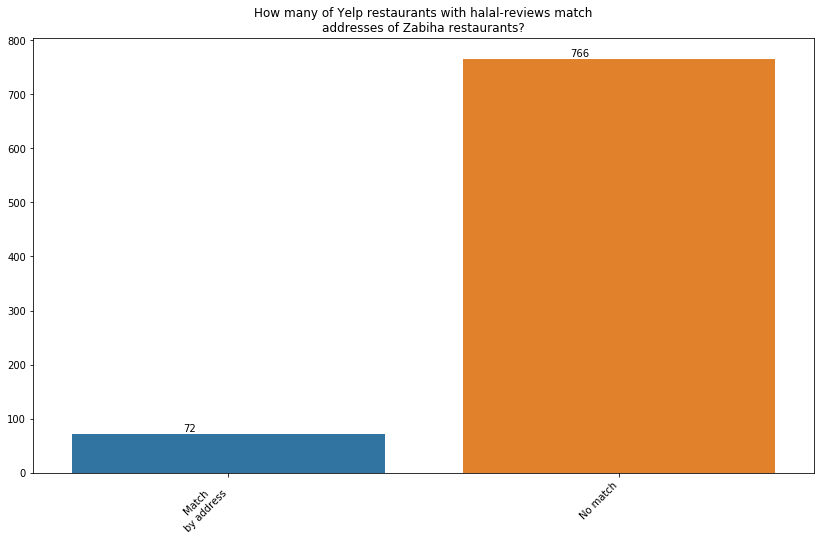

In [7]:
# cleanup yelp address to match validated addresses
yelp_df.address = yelp_df.address.str.lower()
yelp_df.address = yelp_df.address.map(lambda address: re.sub(r'[^A-Za-z0-9, ]+', '', address).split(','))
yelp_df.address = yelp_df.address.map(lambda address: ', '.join([str.strip() for str in address])+', usa')

# only yelp businesses with halal reviews
halal_mask = yelp_df['platform_id'].isin(reviews_df['restaurant_id'].unique())
halal_df = yelp_df[halal_mask]

# only Zabiha results
zabiha_df = target_df[ target_df.source == 'Zabiha']

# overlap with Zabiha.com by address
address_match = halal_df['address'].isin(zabiha_df['validated_address'])
address_match_count = [sum(address_match), len(address_match)-sum(address_match)]

plt.figure(figsize=(14,8))
g = sns.barplot(x=['Match    \nby address','No match'], y=address_match_count)
g.set_title('How many of Yelp restaurants with halal-reviews match\naddresses of Zabiha restaurants?')
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                ha='center', va='bottom', color= 'black')

## How about Yelp restaurants (838) with halal reviews that match halal-confirmed restaurants (340) from Zomato.com?

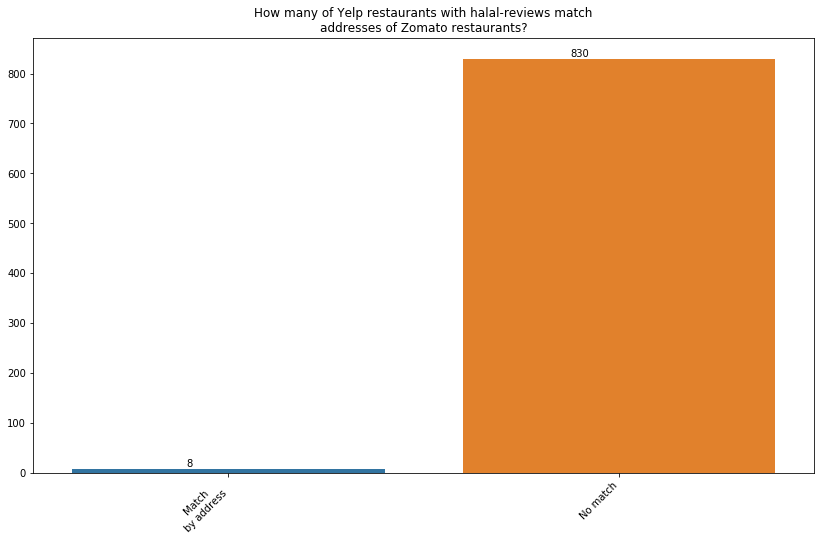

In [8]:
# only Zabiha results
zomato_df = target_df[ target_df.source == 'Zomato']
# overlap with Zabiha.com by address
address_match = halal_df['address'].isin(zomato_df['validated_address'])
address_match_count = [sum(address_match), len(address_match)-sum(address_match)]

plt.figure(figsize=(14,8))
g = sns.barplot(x=['Match    \nby address','No match'], y=address_match_count)
g.set_title('How many of Yelp restaurants with halal-reviews match\naddresses of Zomato restaurants?')
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                ha='center', va='bottom', color= 'black')

## Do the Zabiha list match any restaurants that don't have halal-reviews?

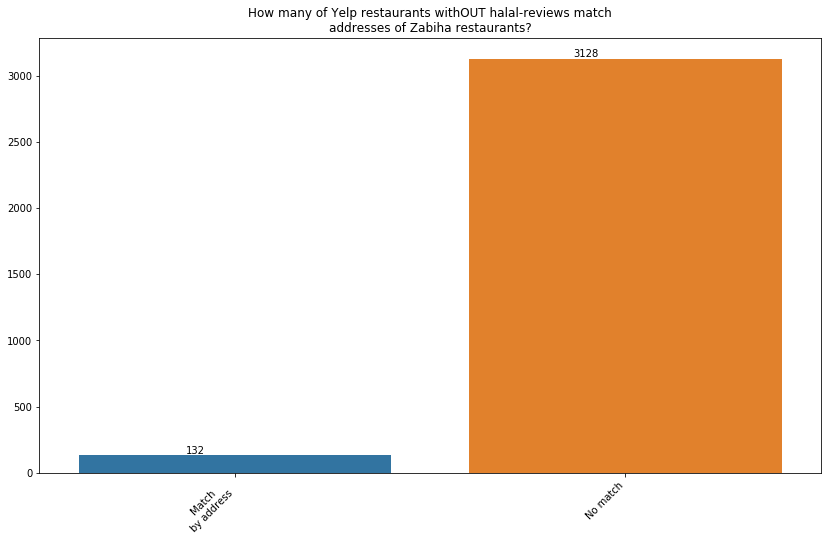

In [9]:
# only yelp businesses withOUT halal reviews
not_halal_mask = yelp_df['platform_id'].isin(reviews_df['restaurant_id'].unique())
not_halal_df = yelp_df[~not_halal_mask]

# overlap with Zabiha.com by address
address_match = not_halal_df['address'].isin(zabiha_df['validated_address'])
address_match_count = [sum(address_match), len(address_match)-sum(address_match)]

plt.figure(figsize=(14,8))
g = sns.barplot(x=['Match    \nby address','No match'], y=address_match_count)
g.set_title('How many of Yelp restaurants withOUT halal-reviews match\naddresses of Zabiha restaurants?')
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                ha='center', va='bottom', color= 'black')

### How many Zabiha restaurants are within NY state?

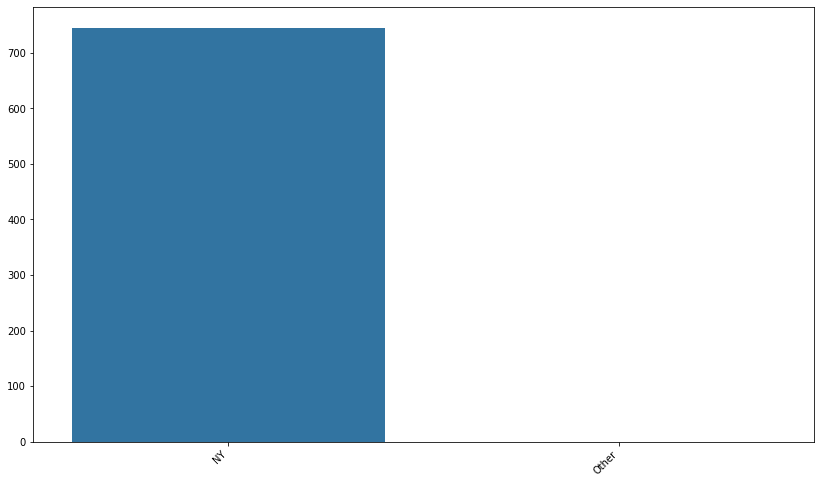

In [10]:
ny_or_not = zabiha_df['address'].apply(lambda x: 'NY' in x)
ny_or_not_count = [sum(ny_or_not), len(ny_or_not)-sum(ny_or_not)]
plt.figure(figsize=(14, 8))
g = sns.barplot(x=['NY','Other'], y=ny_or_not_count)
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

## Are my restaurants of interest even in NYC?

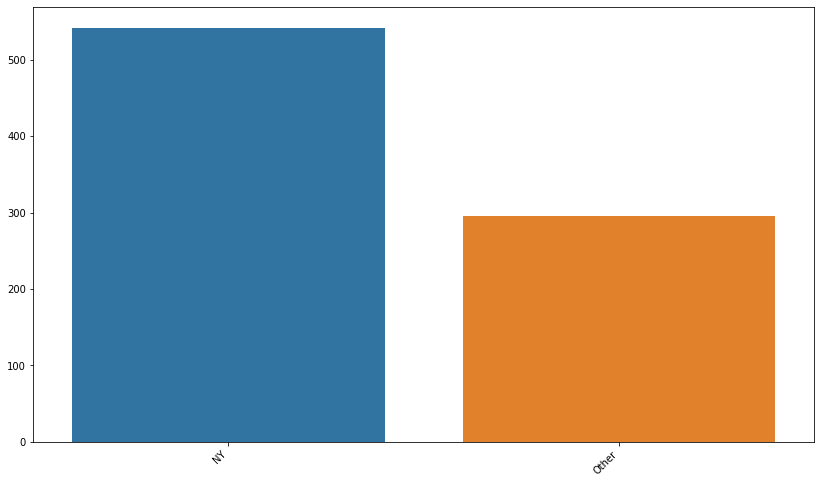

In [11]:
ny_or_not = halal_df['address'].apply(lambda x: ' ny ' in x)
ny_or_not_count = [sum(ny_or_not), len(ny_or_not)-sum(ny_or_not)]
plt.figure(figsize=(14, 8))
g = sns.barplot(x=['NY','Other'], y=ny_or_not_count)
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

# New Approach:
## Match restaurants by coordinate distance & name similarity
### 1. Add coordinates and image_url data to restaurants of interest (halal_df)

In [3]:
from importlib import reload 
import Yelp_business_search
import json


c=0
# halal_df['image_url'] = None
for i, yelp_id in halal_df['platform_id'].iteritems():
    if pd.isna(halal_df.loc[i, 'image_url']):
        try:
            row = Yelp_business_search.get_yelp_business_details(yelp_id)
            halal_df.loc[i, 'image_url'] = row['image_url']
            halal_df.loc[i, 'lat'] = row['lat']
            halal_df.loc[i, 'lng'] = row['lng']
            time.sleep(0.2)
        except:
            row = Yelp_business_search.get_yelp_business_details(yelp_id)
            halal_df.loc[i, 'image_url'] = row['image_url']
            halal_df.loc[i, 'lat'] = row['lat']
            halal_df.loc[i, 'lng'] = row['lng']
            time.sleep(0.2)
    c+=1
    print('[{0}/{1}] id:{2}'.format(c, halal_df.shape[0], yelp_id), end='\r', flush=True )

ModuleNotFoundError: No module named 'Yelp_business_search'

## Find appropriate thresholds
### 2.1. Find closest restaurant to the restaurant of interest from Zabiha's list with coordinates

In [2]:
zabiha_df = pd.read_csv('/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/data/data_collection/target_feature/zabiha_list.csv')
zabiha_df['lat'] = zabiha_df['coordinates'].apply(lambda x: float(x.split(',')[0]))
zabiha_df['lng'] = zabiha_df['coordinates'].apply(lambda x: float(x.split(',')[1]))
zabiha_df.head()

NameError: name 'pd' is not defined

In [46]:
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    dist = 12742 * asin(sqrt(a)) # [km]
    return dist

def closest(v, data):
    return min(data, key=lambda p: distance(v['lat'],v['lng'],data[p]['lat'],data[p]['lng']))

halal_dict = {row['name']: {'lat' : row.lat, 'lng' : row.lng}  for _,row in halal_df.iterrows()}
zabiha_dict = {row['name']: {'lat' : row.lat, 'lng' : row.lng}  for _,row in zabiha_df.iterrows()}

c=0
for i, res_name in halal_df['name'].iteritems():
    res = closest(halal_dict[res_name], zabiha_dict)
    halal_df.loc[i, 'zabiha_name'] = res
    halal_df.loc[i, 'zabiha_lat'] = zabiha_dict[res]['lat']
    halal_df.loc[i, 'zabiha_lng'] = zabiha_dict[res]['lng']
    halal_df.loc[i, 'zabiha_distance'] = distance(halal_df.loc[i, 'lat'], halal_df.loc[i, 'lng'],
                                           zabiha_dict[res]['lat'], zabiha_dict[res]['lng'])
    c+=1
    print('Progress: {0}/{1}'.format(c, halal_df.shape[0]), end='\r', flush=True)

/Users/wesamazaizeh/miniconda3/envs/sm-project/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/wesamazaizeh/miniconda3/envs/sm-project/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


,name,platform_id,url,total_review_count,address,id,halal_review_count,image_url,lat,lng,zabiha_name,zabiha_lat,zabiha_lng,distance,similarity_score,mfoodies_name,mfoodies_lat,mfoodies_lng,mfoodies_distance,zabiha_distance
0,Peri Peri Grill House,KPGZ6zr6lUX9YROjGcUbtw,https://www.yelp.com/biz/peri-peri-grill-house...,146.0,"235 malcolm x blvd, brooklyn, ny 11233, usa",5178,9.0,https://s3-media3.fl.yelpcdn.com/bphoto/Pua9bm...,40.684740,-73.929160,Taj Masala,40.684379,-73.929667,6.157025,0.129032,Krave Shack,40.721219,-73.984109,6.157025,0.058642
2,Gyro Mania,ctVgx_mIwt2Fwc48Pgjhlw,https://www.yelp.com/biz/gyro-mania-bath-beach...,41.0,"2151 bath ave, bath beach, ny 11214, usa",5180,9.0,https://s3-media4.fl.yelpcdn.com/bphoto/vlTRc6...,40.598944,-73.997939,Gyro Mania,40.599002,-73.997967,11.670833,1.000000,Kabul Kabob House,40.703428,-74.011081,11.670833,0.006884
3,Middle Eastern Halal Food,WekK6vHrQZ-81CijH2sGiw,https://www.yelp.com/biz/middle-eastern-halal-...,146.0,"8601 5th ave, brooklyn, ny 11209, usa",5182,20.0,https://s3-media1.fl.yelpcdn.com/bphoto/Wi3R2J...,40.621258,-74.026194,Your House CafÃ©,40.634310,-74.023942,9.225376,0.146341,Kabul Kabob House,40.703428,-74.011081,9.225376,1.463746
20,Joloff Restaurant,FdB6KDTEmX8HvomPwySAHg,https://www.yelp.com/biz/joloff-restaurant-bro...,185.0,"1168 bedford ave, brooklyn, ny 11216, usa",5198,2.0,https://s3-media3.fl.yelpcdn.com/bphoto/fW320I...,40.684100,-73.954220,Joloff,40.684151,-73.954076,4.835691,0.521739,Krave Shack,40.721219,-73.984109,4.835691,0.013401
22,First Oasis,KjqBMZ0bE9VV2VP3DrDZvg,https://www.yelp.com/biz/first-oasis-brooklyn?...,169.0,"9218 4th ave, brooklyn, ny 11209, usa",5200,2.0,https://s3-media3.fl.yelpcdn.com/bphoto/bPTsFk...,40.618030,-74.030650,First Oasis,40.617958,-74.030571,9.638222,1.000000,Kabul Kabob House,40.703428,-74.011081,9.638222,0.010426


### 2.2. Add name similarity score

In [1]:
from difflib import SequenceMatcher
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

for i,_ in halal_df.iterrows():
    s = SequenceMatcher(None, halal_df.loc[i, 'name'], halal_df.loc[i, 'zabiha_name']).ratio()
    halal_df.loc[i, 'zabiha_similarity'] = s

a = sns.jointplot(y='zabiha_similarity', x='zabiha_distance', data=halal_df, height=10)
# highlight possible threshhold area
elps = Ellipse((0, 0.8), 350, 0.5,edgecolor='r',facecolor='none')
ax = a.ax_joint
ax.add_artist(elps)
plt.show()

NameError: name 'halal_df' is not defined

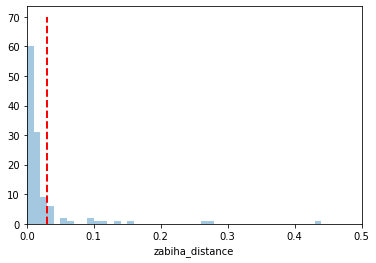

In [92]:
# plot distribution of distance for all zabiha with similarity higher than 0.5 very close to the restaurant of interest
sns.distplot(halal_df[halal_df['zabiha_similarity'] > 0.5]['zabiha_distance'], kde=False, bins=np.arange(0.0, 1.0, 0.01))
plt.xlim(0, 0.5)
plt.plot([.03, .03],[0, 70], linewidth=2, linestyle='dashed', color='r') # cutoff between 2 & 5. To remove noise
plt.show()

In [89]:
halal_df[(halal_df['zabiha_similarity'] > 0.5) & (halal_df['zabiha_distance'] < 0.3)][['name', 'zabiha_name']]

,name,zabiha_name
2,Gyro Mania,Gyro Mania
20,Joloff Restaurant,Joloff
22,First Oasis,First Oasis
30,Abir Halal Restaurant,Abir Halal
36,Halal Paradise,Halal Paradise Truck
...,...,...
3700,Krispy Krunchy Chicken,Krispy Krunchy Chicken
3729,Namaste Tashi Delek,Namaste Tashi Delek
3731,Bosna Express,Bosna Express
3932,Nanking,Nanking


Criteria: 
    - distance less than 30m
    - name similarity score greater than 0.5

In [25]:
mfoodies_df = pd.read_csv('/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/data/data_collection/target_feature/muslim_foodies_list.csv')
mfoodies_df['lat'] = zabiha_df['coordinates'].apply(lambda x: float(x.split(',')[0]))
mfoodies_df['lng'] = zabiha_df['coordinates'].apply(lambda x: float(x.split(',')[1]))
mfoodies_df.head()

,name,coordinates,category,url,lat,lng
0,ADDY’S BARBEQUE,"-73.9170111,40.7617052",MFoodies,NaN,40.816647,-73.939216
1,Farida Central Asian Cuisine & Grill,"-73.9944464,40.7556662",MFoodies,NaN,40.743193,-73.990838
2,YANA - Uyghur Kebab Express,"-73.983442,40.76551",MFoodies,NaN,40.704051,-74.009020
3,Fitoor Cafe & Grill Lounge,"-73.7882865,40.7265806",MFoodies,NaN,40.814514,-73.959663
4,Firdos Grill,"-73.9119015,40.767307",MFoodies,NaN,40.726791,-73.987791


/Users/wesamazaizeh/miniconda3/envs/sm-project/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/wesamazaizeh/miniconda3/envs/sm-project/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


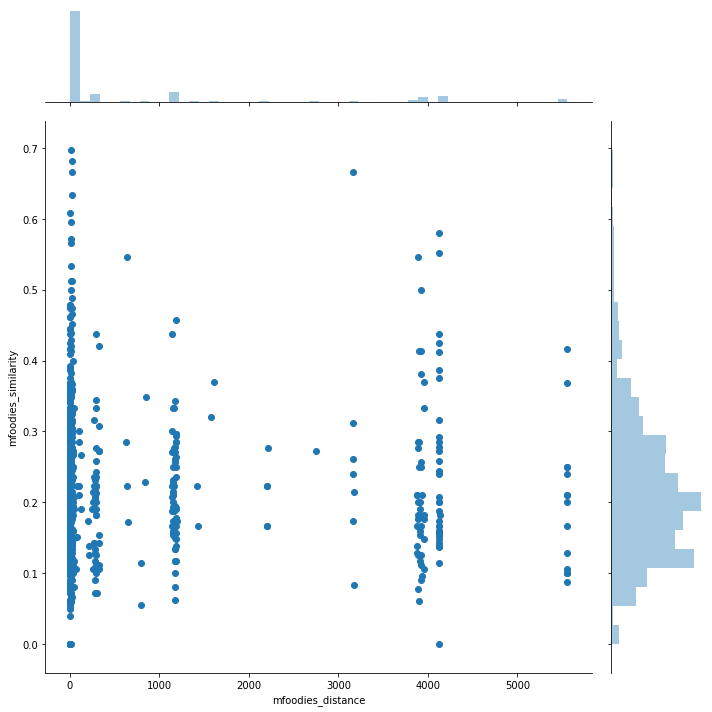

In [50]:
# mfoodies_dict = {row['name']: {'lat' : row.lat, 'lng' : row.lng}  for _,row in mfoodies_df.iterrows()}

c=0
for i, res_name in halal_df['name'].iteritems():
    res = closest(halal_dict[res_name], mfoodies_dict)
    halal_df.loc[i, 'mfoodies_name'] = res
    halal_df.loc[i, 'mfoodies_lat'] = mfoodies_dict[res]['lat']
    halal_df.loc[i, 'mfoodies_lng'] = mfoodies_dict[res]['lng']
    halal_df.loc[i, 'mfoodies_distance'] = distance(halal_df.loc[i, 'lat'], halal_df.loc[i, 'lng'],
                                           mfoodies_dict[res]['lat'], mfoodies_dict[res]['lng'])
    s = SequenceMatcher(None, halal_df.loc[i, 'name'], halal_df.loc[i, 'mfoodies_name']).ratio()
    halal_df.loc[i, 'mfoodies_similarity'] = s
    c+=1
    print('Progress: {0}/{1}'.format(c, halal_df.shape[0]), end='\r', flush=True)


a = sns.jointplot(y='mfoodies_similarity', x='mfoodies_distance', data=halal_df, height=10)
plt.show()

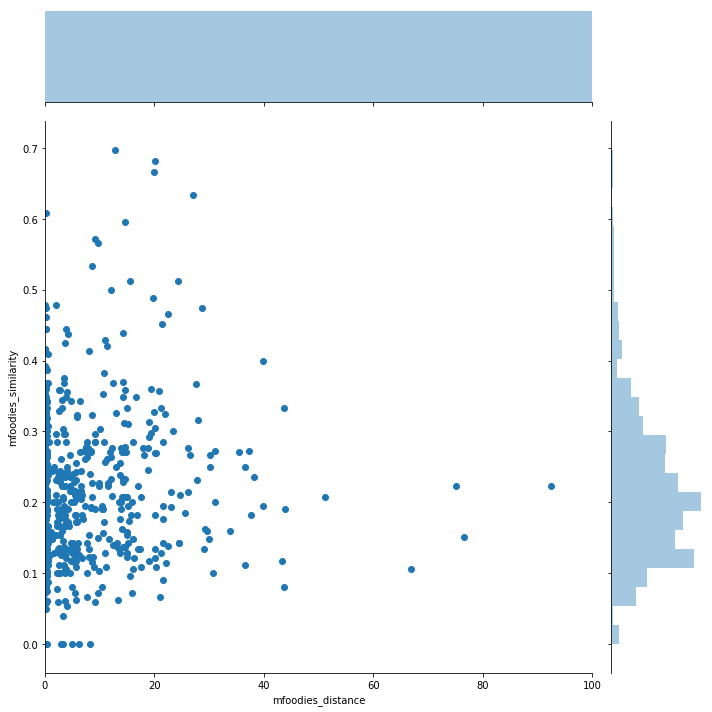

In [56]:
a = sns.jointplot(y='mfoodies_similarity', x='mfoodies_distance', data=halal_df, height=10, xlim=(0,100))
plt.show()